在Baseline的单资产DLinear模型上，预测结果取得了稳定的超额准确率，但是也会出现几个问题

1. 由于单资产的数据量有限，导致训练集规模不够大， 容易出现过拟合现象，导致学习不充分

2. 由于模型需要在“预测结果本身是Neutral分类”和“对当前样本做出的预测不够有信心” 两种情况下都要选择放弃预测，从而导致整体预测结果会出现比真实结果更多的Neutral 分类（约90%），模型仅对10%的样本选择做出预测。

为了能提高资金利用效率，防止模型在大多数情况下都在被动等待，我们可以在单资产DLinear Model的基础上，扩展资产的数量，一方面增大数据集，另一方面降低资金利用效率。

在这一阶段，我们暂时还不考虑引入跨资产的截面数据关系，假定这些资产之间是完全无关的，这也符合PatchTST中通道独立的假设，

除了上证50、沪深300、中证500股指期货以外，我们选取了一些成交量好，与宏观经济有强关联的资产种类，例如黄金、原油、焦煤、螺纹钢、热卷、铁矿石、豆粕、棉花

但是由于不同的期货品种共用模型参数，而资产的波动率、行为模式存在差异，导致模型的预测能力下降了。

对此，我们可以有两个解决方法

1. 两阶段训练模式，先训练整体，再根据目标微调参数

2. 增加资产信息维度，将资产信息嵌入到价格数据中，让模型学会根据资产信息改变参数

我们先实现第一种思路

In [1]:
import os
os.chdir('d:/future/index_future_prediction/Index_Future_Prediction')

In [2]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from scipy.stats import norm, t

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
from utils.random_split import RandomSplit, CallableDataset
from utils.back_test import BackTest
from utils.hybrid_loss import HybridLoss
from utils.hybrid_decoder import HybridDecoder
from utils.prediction_recorder import PredictionRecorder
from utils.train_animator import TrainAnimator
from utils.model_train import ModelTrain

In [4]:
import tushare as ts
pro = ts.pro_api('700c1d6015ad030ff20bf310c088243da030e6b79a2a1098d58d2614')

In [5]:
from modules.dlinear import DLinear
class DLinearOutput(nn.Module):
    """循环神经网络模型"""
    def __init__(self, seq_len, pred_len, individual, enc_in, kernel_size, init_prob, dropout, **kwargs):
        super(DLinearOutput, self).__init__(**kwargs)
        self.device = 'cuda:0'

        self.process = nn.Sequential(
            DLinear(seq_len = seq_len, pred_len =  pred_len, individual = individual, enc_in = enc_in, kernel_size = kernel_size),
            nn.Sequential(nn.Flatten(start_dim = 1), nn.Dropout(dropout))
            )


        self.output = HybridDecoder(pred_len * enc_in, init_prob = init_prob)

    def forward(self, x):
        x = self.process(x)
        return self.output(x)

In [6]:
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 
               'AU.SHF', 'FU.SHF', 'JM.DCE',
               'RB.SHF','HC.SHF', 
               'I.DCE', 'M.DCE', 
               'CF.ZCE',
               ]

In [7]:
feature = ['log_open','log_high','log_low','log_close','log_amount']
label = ['label_return','down_prob','middle_prob','up_prob']

In [8]:
start_date = '20150101'
split_date = '20200101'
end_date = '20250101'

In [9]:
window_size = 40
pred_len = 5

In [10]:
def get_data_set(assets_list):
    train_set = None
    validation_set = None
    for code in assets_list:
        data = pro.fut_daily(ts_code = code, start_date = start_date, end_date = split_date)
        data['oi_chg'] = 1
        data.dropna(inplace=True)
        data.sort_values(by = 'trade_date', inplace = True)
        data['log_open'] = np.log(data['open'] / data['pre_close']) * 100 #标准化为对数百分比（不含百分号）
        data['log_high'] = np.log(data['high'] / data['pre_close']) * 100 
        data['log_low'] = np.log(data['low'] / data['pre_close']) * 100 
        data['log_close'] = np.log(data['close'] / data['pre_close']) * 100
        data['log_amount'] = np.log(data['amount'] / data['amount'].shift(1)) * 10

        data['label_return'] = data['log_close'].rolling(window = pred_len).sum().shift(-pred_len) # 标准化为对数百分比（不含百分号），可以直接相加
        data['label_std'] = data['amount'].rolling(window = pred_len).mean().shift(-pred_len)/data['amount'].mean() * data['label_return'].std()

        threshold = (abs(data['label_return'].quantile(0.7)) + abs(data['label_return'].quantile(0.3)))/2
        amount_mean = data['amount'].mean()
        return_std = data['label_return'].std()

        def down_probability(row):
            return norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

        def middle_probability(row):
            return norm.cdf(threshold, loc = row['label_return'], scale=row['label_std']) - norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

        def up_probability(row):
            return 1 - norm.cdf(threshold, loc = row['label_return'], scale=row['label_std'])
        
        data['down_prob'] = data.apply(down_probability, axis = 1)
        data['middle_prob'] = data.apply(middle_probability, axis = 1)
        data['up_prob'] = data.apply(up_probability, axis = 1)
        
        data.dropna(inplace=True)

        feature_tensor = torch.tensor(data[feature].values, dtype = torch.float32, device = 'cuda:0')
        feature_tensor = feature_tensor.unfold(dimension = 0, size = window_size, step = 1).transpose(1,2)

        label_tensor = torch.tensor(data[label].values, dtype = torch.float32, device = 'cuda:0')
        label_tensor = label_tensor[window_size-1:]

        if train_set == None:
        
            train_set = CallableDataset(feature_tensor, label_tensor)
        else:
            train_set = train_set + CallableDataset(feature_tensor, label_tensor)

        
        
        data = pro.fut_daily(ts_code = code, start_date = split_date, end_date = end_date)
        data['oi_chg'] = 1
        data.dropna(inplace=True)
        data.sort_values(by = 'trade_date', inplace = True)
        data['log_open'] = np.log(data['open'] / data['pre_close']) * 100 
        data['log_high'] = np.log(data['high'] / data['pre_close']) * 100 
        data['log_low'] = np.log(data['low'] / data['pre_close']) * 100 
        data['log_close'] = np.log(data['close'] / data['pre_close']) * 100
        data['log_amount'] = np.log(data['amount'] / data['amount'].shift(1)) * 10

        data['label_return'] = data['log_close'].rolling(window = pred_len).sum().shift(-pred_len)
        data['label_std'] = data['amount'].rolling(window = pred_len).mean().shift(-pred_len) / amount_mean * return_std

        def down_probability(row):
            return norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

        def middle_probability(row):
            return norm.cdf(threshold, loc = row['label_return'], scale=row['label_std']) - norm.cdf(-threshold, loc = row['label_return'], scale=row['label_std'])

        def up_probability(row):
            return 1 - norm.cdf(threshold, loc = row['label_return'], scale=row['label_std'])
        
        data['down_prob'] = data.apply(down_probability, axis = 1)
        data['middle_prob'] = data.apply(middle_probability, axis = 1)
        data['up_prob'] = data.apply(up_probability, axis = 1)

        threshold_test = (abs(data['label_return'].quantile(0.75)) + abs(data['label_return'].quantile(0.25)))/2

        print(f'{code}: train threshold: {threshold:.2f}, test threshold: {threshold_test:.2f}')

        data.dropna(inplace=True)

        feature_tensor = torch.tensor(data[feature].values, dtype = torch.float32, device = 'cuda:0')
        feature_tensor = feature_tensor.unfold(dimension = 0, size = window_size, step = 1).transpose(1,2)

        label_tensor = torch.tensor(data[label].values, dtype = torch.float32, device = 'cuda:0')
        label_tensor = label_tensor[window_size-1:]

        if validation_set == None:
        
            validation_set = CallableDataset(feature_tensor, label_tensor)
        else:
            validation_set = validation_set + CallableDataset(feature_tensor, label_tensor)
            
    test_set = validation_set

    return train_set, validation_set, test_set

In [11]:
train_set, validation_set, test_set = get_data_set(assets_list)

IH.CFX: train threshold: 1.27, test threshold: 1.58
IF.CFX: train threshold: 1.40, test threshold: 1.59
IC.CFX: train threshold: 1.66, test threshold: 1.59
AU.SHF: train threshold: 0.73, test threshold: 0.97
FU.SHF: train threshold: 2.09, test threshold: 3.31
JM.DCE: train threshold: 1.67, test threshold: 3.42
RB.SHF: train threshold: 1.81, test threshold: 2.00
HC.SHF: train threshold: 1.70, test threshold: 1.94
I.DCE: train threshold: 2.48, test threshold: 3.45
M.DCE: train threshold: 1.17, test threshold: 1.76
CF.ZCE: train threshold: 1.02, test threshold: 1.63


In [12]:
train_set_fine_tuning, validation_set_fine_tuning, test_set_fine_tuning = get_data_set(['IH.CFX'])

IH.CFX: train threshold: 1.27, test threshold: 1.58


In [13]:
train_set.all()[0].shape

torch.Size([12121, 40, 5])

In [14]:
test_set_fine_tuning.all()[0].shape

torch.Size([1167, 40, 5])

In [15]:
recorder = PredictionRecorder()
animator = TrainAnimator(figsize=(12,6))

Animator data has been reset.


实现两阶段的训练，由于设置了学习率调度器，在一阶段结束的时候学习率已经被调度到了一个相当低的水平，就不需要重新设置学习率了

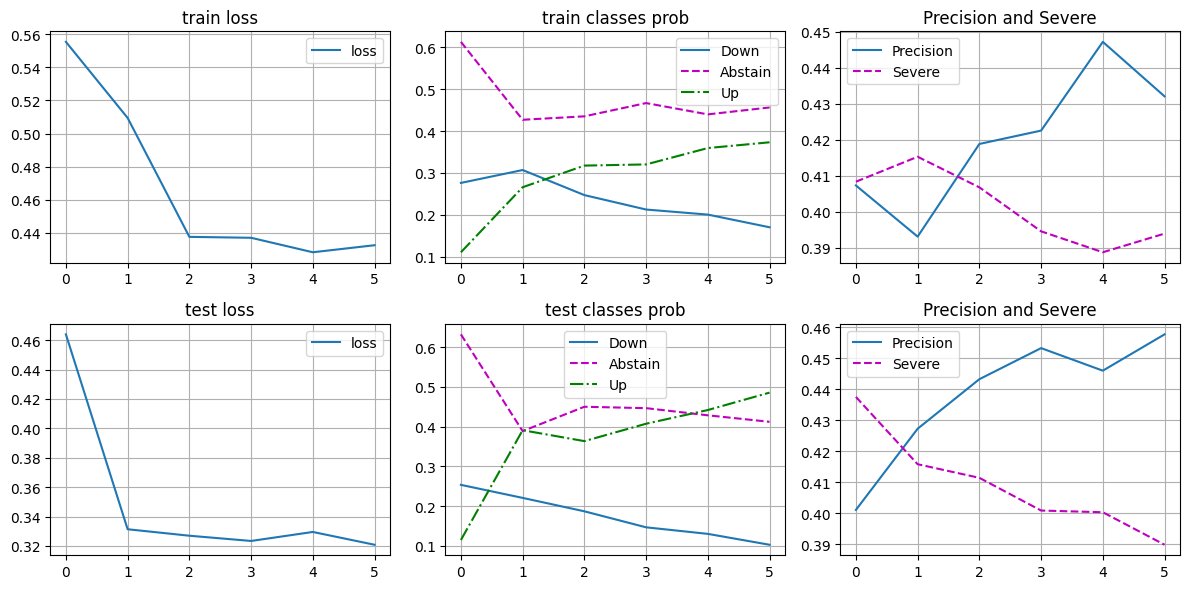

 60%|██████    | 60/100 [00:00<00:00, 260.49it/s]


KeyboardInterrupt: 

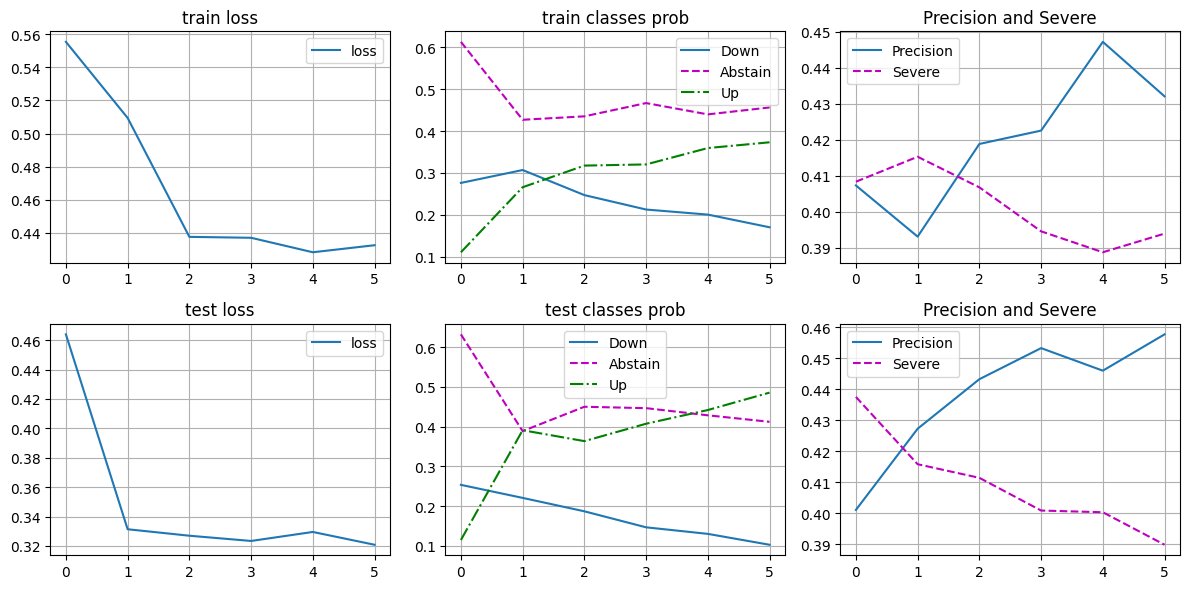

In [16]:
gap = []
for i in range(10):
    
    animator.reset()
    model = DLinearOutput(seq_len = 40, pred_len = 5, individual = True, enc_in = 5, kernel_size = 21, init_prob = [0.0, 1, 0.0], dropout = 0.5).to('cuda:0')
    loss_fn = HybridLoss(alpha = 1e-3, delta = 1)


    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 1e-1)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
    train = ModelTrain(model = model,
                       batch_size = 100,
                   train_set = train_set,
                   validation_set = validation_set,
                   test_set = test_set,
                   loss_fn = loss_fn,
                   optimizer = optimizer,
                   scheduler=scheduler,
                   recorder=recorder,
                   graph=animator,
                   )
    precision, severe = train.epoch_train(epochs = 10, round = 100, early_stop = 10)

    print('first_finish')

    train.train_set = train_set_fine_tuning
    train.validation_set = validation_set_fine_tuning
    train.test_set = test_set_fine_tuning


    precision, severe = train.epoch_train(epochs = 3, round = 100, early_stop = 10)

    gap.append(precision - severe)


In [ ]:
print(f'超额正确率均值  ：{np.mean(gap):.2%}')
print(f'超额正确率标准差：{np.std(gap):.2%}')

超额正确率均值  ：22.93%
超额正确率标准差：12.78%


可以看到，相比于单一学习的11%，多资产混合学习的7%，两阶段模式取得了显著的正确率提升，过拟合现象也有所缓解。

缺点仍然存在，在二阶段学习时，模型的预测比例仍然会回退到一阶段的10%左右。

In [ ]:
# torch.save(model.state_dict(), 'params/baseline.params')